## Exploratory data analysis

Motivation behind EDA chapter is to have a grasp on data and how representative are some features. The major goal is to drop completely uninteresting features, because we anyways have a lot of them.

In [1]:
import os
import time

from pprint import pprint
from itertools import chain

import numpy as np
import scipy as sp
from scipy import sparse
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (18,12)

import uproot

In [2]:
data_path = "/afs/cern.ch/user/a/ananiev/cernbox/data/"

For training the classifier we will need only MC data, because only MC has labels.

In [3]:
datasets = {
    "GamGam": {
        "MC": [
            ("mc_341081.ttH125_gamgam.GamGam", {"tag": "tt"}),
            ("mc_343981.ggH125_gamgam.GamGam", {"tag": "gg"}),
            ("mc_345041.VBFH125_gamgam.GamGam", {"tag": "VBF"}),
            ("mc_345318.WpH125J_Wincl_gamgam.GamGam", {"tag": "WH"}),
            ("mc_345319.ZH125J_Zincl_gamgam.GamGam", {"tag": "ZH"})

        ]
    }
}

In [4]:
test_mc = uproot.open(os.path.join("root://", data_path, "GamGam", "MC", f"{datasets['GamGam']['MC'][0][0]}.root"))

In [5]:
test_mc_events = next(test_mc["mini"].iterate(["*"], entrystop=10000))

We begin from the full list of features present in the ATLAS OpenData root files:

In [6]:
test_mc["mini"].keys()

[b'runNumber',
 b'eventNumber',
 b'channelNumber',
 b'mcWeight',
 b'scaleFactor_PILEUP',
 b'scaleFactor_ELE',
 b'scaleFactor_MUON',
 b'scaleFactor_PHOTON',
 b'scaleFactor_TAU',
 b'scaleFactor_BTAG',
 b'scaleFactor_LepTRIGGER',
 b'scaleFactor_PhotonTRIGGER',
 b'trigE',
 b'trigM',
 b'trigP',
 b'lep_n',
 b'lep_truthMatched',
 b'lep_trigMatched',
 b'lep_pt',
 b'lep_eta',
 b'lep_phi',
 b'lep_E',
 b'lep_z0',
 b'lep_charge',
 b'lep_type',
 b'lep_isTightID',
 b'lep_ptcone30',
 b'lep_etcone20',
 b'lep_trackd0pvunbiased',
 b'lep_tracksigd0pvunbiased',
 b'met_et',
 b'met_phi',
 b'jet_n',
 b'jet_pt',
 b'jet_eta',
 b'jet_phi',
 b'jet_E',
 b'jet_jvt',
 b'jet_trueflav',
 b'jet_truthMatched',
 b'jet_MV2c10',
 b'photon_n',
 b'photon_truthMatched',
 b'photon_trigMatched',
 b'photon_pt',
 b'photon_eta',
 b'photon_phi',
 b'photon_E',
 b'photon_isTightID',
 b'photon_ptcone30',
 b'photon_etcone20',
 b'photon_convType',
 b'tau_n',
 b'tau_pt',
 b'tau_eta',
 b'tau_phi',
 b'tau_E',
 b'tau_isTightID',
 b'tau_tru

In [7]:
def yield_files_with_meta(datasets):
    for process_name, process in datasets.items():
        print("Process: ", process_name)
        for type_name, thetype in process.items():
            print("Type: ", type_name)
            for filedata in thetype:
                try:
                    filename, meta = filedata
                except ValueError:
                    filename = filedata
                    meta = {}
                print("File: ", filename)
                fullpath = os.path.join("root://", data_path, process_name, type_name, f"{filename}.root")
                yield (process_name, type_name, filename), fullpath, meta

In [8]:
def dict_apply_mask(d, mask, fields=None):
    if fields is None:
        fields = d.keys()
    for f in fields:
        d[f] = d[f][mask]

In [9]:
def eta2tg_theta(eta):
    tg_theta = np.exp(-eta)
    tg_theta = 2*tg_theta**2/(1 - tg_theta**2)
    return tg_theta

In [10]:
def atlas_two_cosine(events, p1, p2):
    tg_theta_1 = eta2tg_theta(events[p1+b"_eta"])
    tg_theta_2 = eta2tg_theta(events[p2+b"_eta"])
    cos_delta_phi = np.cos(events[p2+b"_phi"] - events[p1+b"_phi"])
    return (cos_delta_phi + tg_theta_1*tg_theta_2)/np.sqrt((tg_theta_1**2 + 1)*(tg_theta_2**2 + 1))

In [11]:
def events_per_file(datasets):
    entrysteps = 100000
    
    events = {}
    for (process, thetype, name), fullpath, meta in yield_files_with_meta(datasets):
        label = meta.get("tag") or f"{process}.{thetype}.{name}"
        with uproot.open(fullpath) as f:
            total_events = f["mini"].numentries
            print("Total Num Events: ", total_events)
            time_start = time.perf_counter()
            for i, data in enumerate(f["mini"].iterate(["*"], entrysteps=entrysteps)):
                events[label] = data
                time_now = time.perf_counter()
                print("Processing: ", (i+1)*entrysteps, "; Time per batch: ", time_now - time_start)
                time_start = time_now
                break
    return events

We fetch first 100000 events from each file, we also measure time we spend for fetching the batch. After the traversal finishes, we end up with a dict of 100000 events per file, named according to file tag.

In [12]:
events = events_per_file(datasets)

Process:  GamGam
Type:  MC
File:  mc_341081.ttH125_gamgam.GamGam
Total Num Events:  576491
Processing:  100000 ; Time per batch:  16.59511667722836
File:  mc_343981.ggH125_gamgam.GamGam
Total Num Events:  1054711
Processing:  100000 ; Time per batch:  4.95306570827961
File:  mc_345041.VBFH125_gamgam.GamGam
Total Num Events:  497468
Processing:  100000 ; Time per batch:  3.0408954811282456
File:  mc_345318.WpH125J_Wincl_gamgam.GamGam
Total Num Events:  113765
Processing:  100000 ; Time per batch:  1.790856369305402
File:  mc_345319.ZH125J_Zincl_gamgam.GamGam
Total Num Events:  230900
Processing:  100000 ; Time per batch:  2.887145197018981


In [13]:
events.keys()

dict_keys(['tt', 'gg', 'VBF', 'WH', 'ZH'])

In [14]:
def per_axis(func, events):
    fig, ax = plt.subplots(3, 2)
    ax_iter = chain.from_iterable(ax)
    main = next(ax_iter)
    for (key, val), the_ax in zip(events.items(), ax_iter):
        func(the_ax, key, val)
        func(main, key, val)
    main.set_title("total")
    return fig

We begin with plotting event numbers for different kinds of particles per source. We see that:

* that jet number can vary in a wide range: 0 - 15, while spread depends on the process.
* photons are usually two here, rarely 3+
* lepton number > 0 mostly occurs for tt and WH events, rarely for others
* tau and large jet events are too rare to take them into account

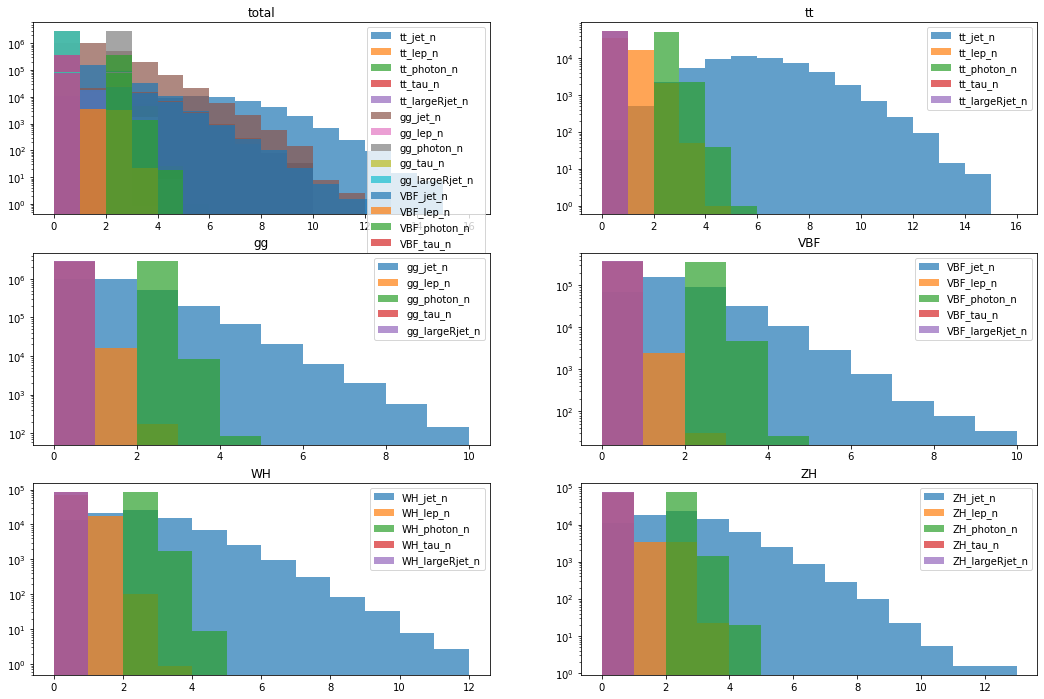

In [52]:
def plot_n_values(ax, key, events):
    max_bin = np.max([events[b"jet_n"],
                      events[b"lep_n"],
                      events[b"photon_n"],
                      events[b"tau_n"],
                      events[b"largeRjet_n"]])
    bin_edges = np.arange(0, max_bin+1., 1.)
    _, bins, _ = ax.hist(events[b"jet_n"], weights=events[b"mcWeight"], label=f"{key}_jet_n", alpha=0.7, bins=bin_edges)
    ax.hist(events[b"lep_n"], weights=events[b"mcWeight"], label=f"{key}_lep_n", bins=bins, alpha=0.7)
    ax.hist(events[b"photon_n"], weights=events[b"mcWeight"], label=f"{key}_photon_n", bins=bins, alpha=0.7)
    ax.hist(events[b"tau_n"], weights=events[b"mcWeight"], label=f"{key}_tau_n", bins=bins, alpha=0.7)
    ax.hist(events[b"largeRjet_n"], weights=events[b"mcWeight"], label=f"{key}_largeRjet_n", bins=bins, alpha=0.7)
    ax.legend()
    ax.set_title(key)
    ax.set_yscale("log")
per_axis(plot_n_values, events).savefig("output/n_particles.png")

Some features might have the same value for most of the events for all the origins, meaning it is useless for discrimination. An example of such a feature is `jet_jvt`.

/afs/cern.ch/user/a/ananiev/projects/venvs/sandbox/lib64/python3.6/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/afs/cern.ch/user/a/ananiev/projects/venvs/sandbox/lib64/python3.6/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


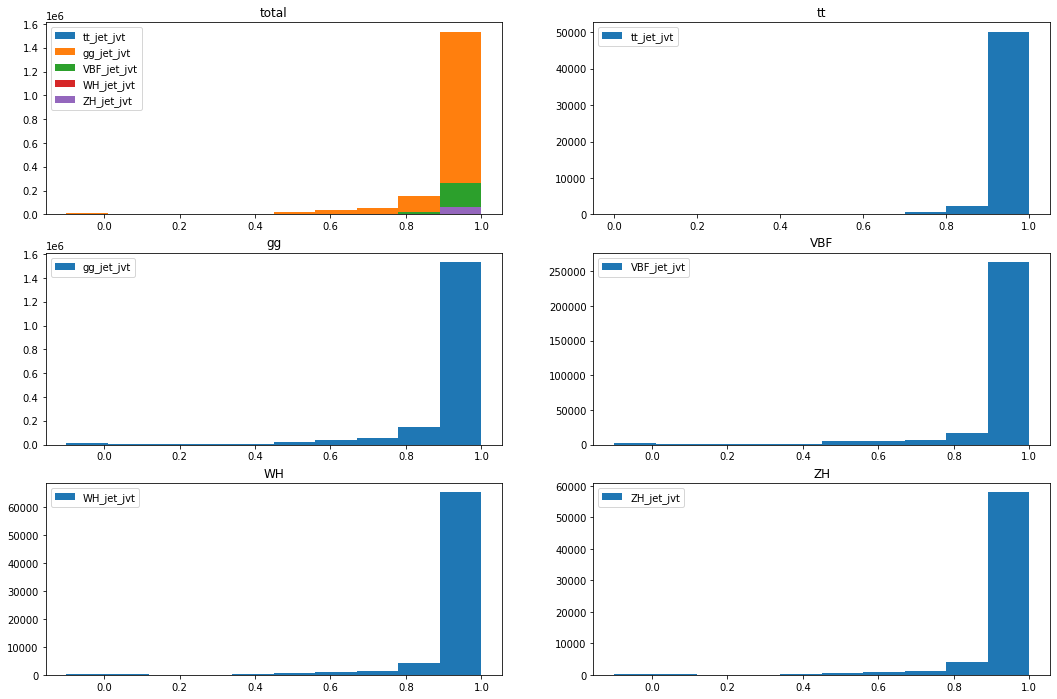

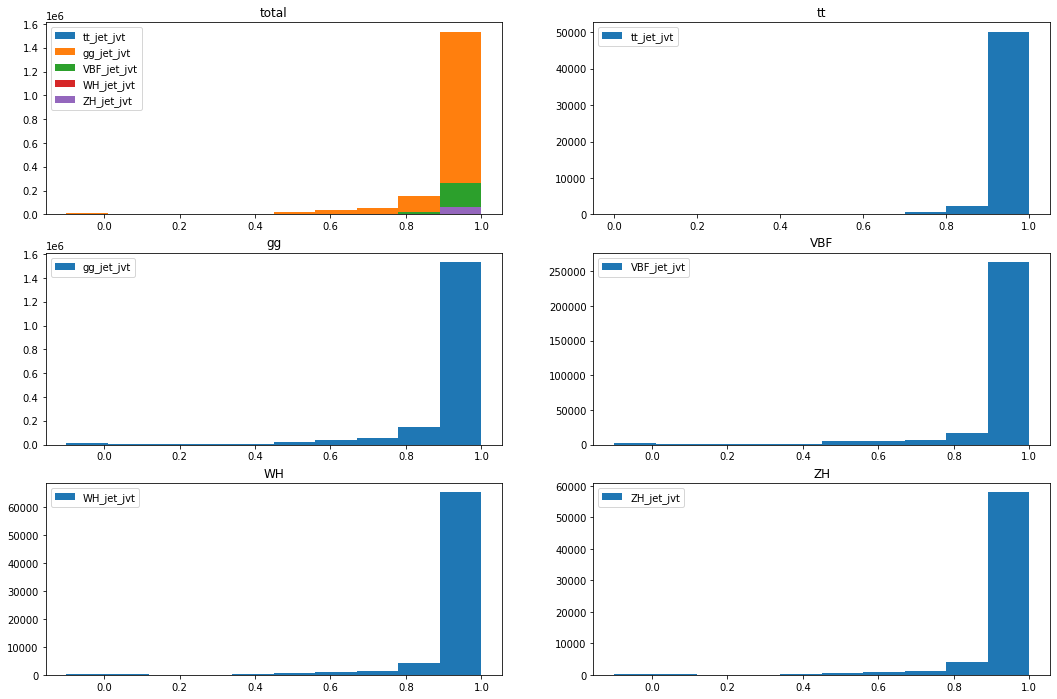

In [16]:
def plot_jet_jvt(ax, key, events):
    ax.hist(events[b"jet_jvt"].mean(), weights=events[b"mcWeight"], label=f"{key}_jet_jvt")
    ax.legend()
    ax.set_title(key)
per_axis(plot_jet_jvt, events)

Feature `jet_MV20c10` is an output of b-tagging algorithm applied to the event. As we can see from the plots, it can serve as a good signature for `tt` events.

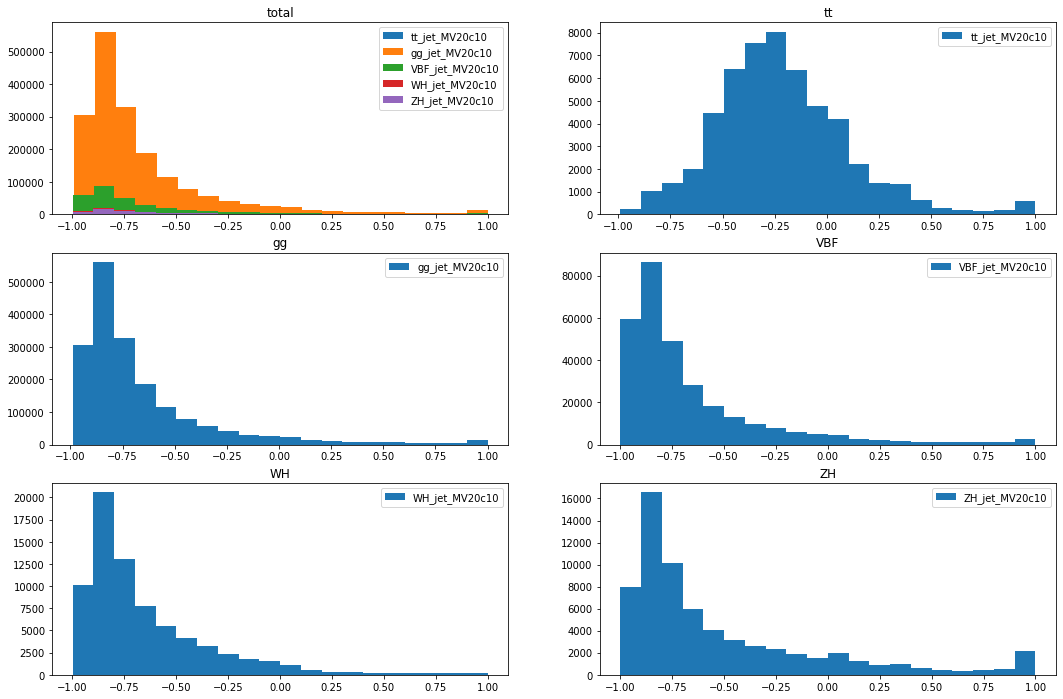

In [49]:
def plot_jet_MV2c10(ax, key, events):
    ax.hist(events[b"jet_MV2c10"].mean(), weights=events[b"mcWeight"], label=f"{key}_jet_MV20c10", bins=20)
    ax.legend()
    ax.set_title(key)
per_axis(plot_jet_MV2c10, events).savefig("output/mv20c10_numbers.png")

To confirm that tau features are irrelevant, let's plot specificly their values per mechanism:

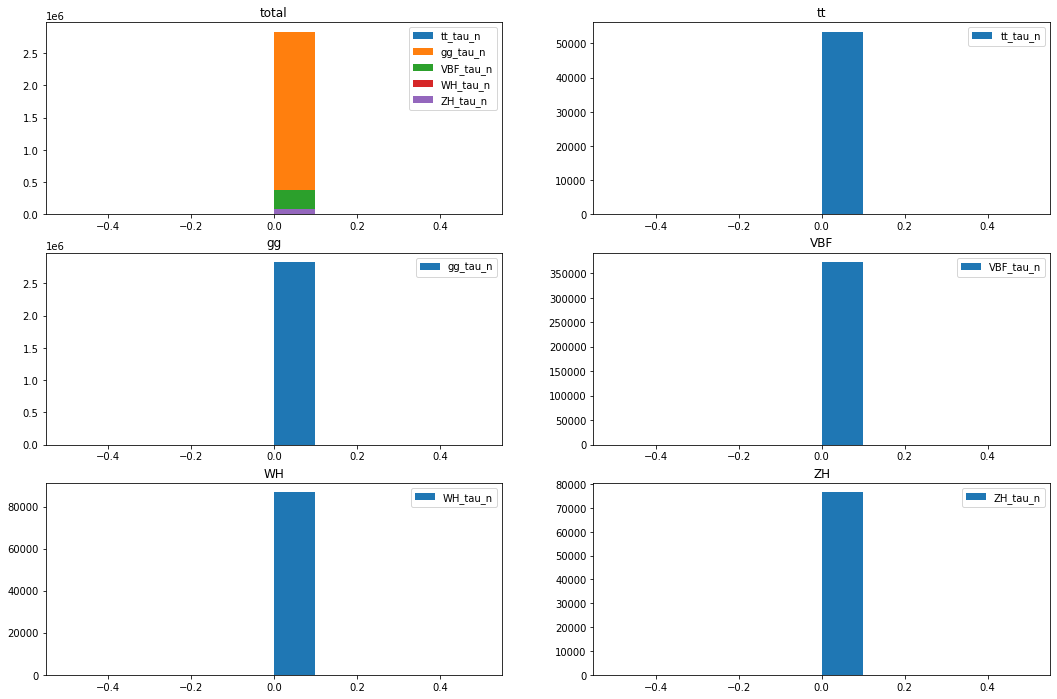

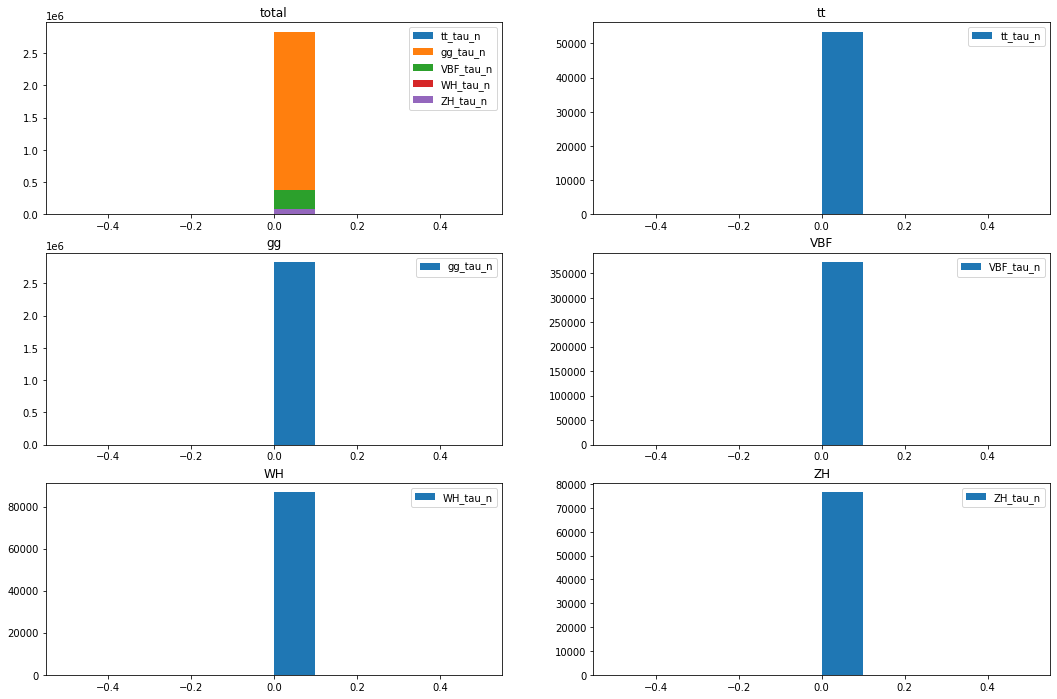

In [18]:
def plot_tau_n(ax, key, events):
    ax.hist(events[b"tau_n"], weights=events[b"mcWeight"], label=f"{key}_tau_n")
    ax.legend()
    ax.set_title(key)
per_axis(plot_tau_n, events)

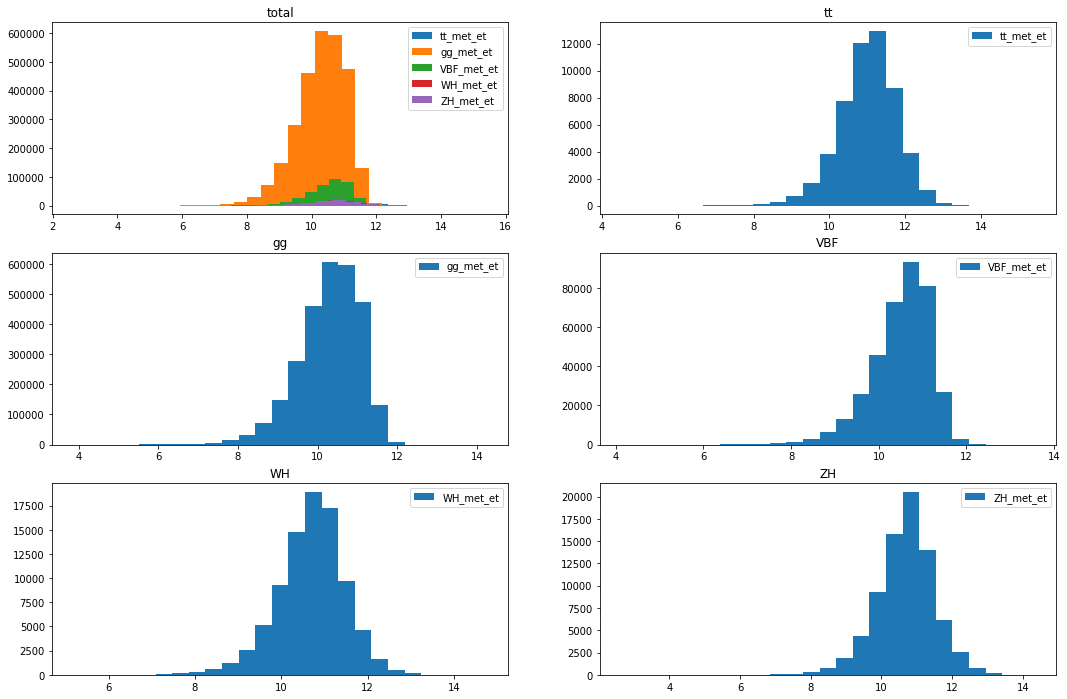

In [48]:
def plot_met_et(ax, key, events):
    ax.hist(np.log(events[b"met_et"]), weights=events[b"mcWeight"], label=f"{key}_met_et", bins=25)
    ax.legend()
    ax.set_title(key)
per_axis(plot_met_et, events).savefig("output/met_et_numbers.png")

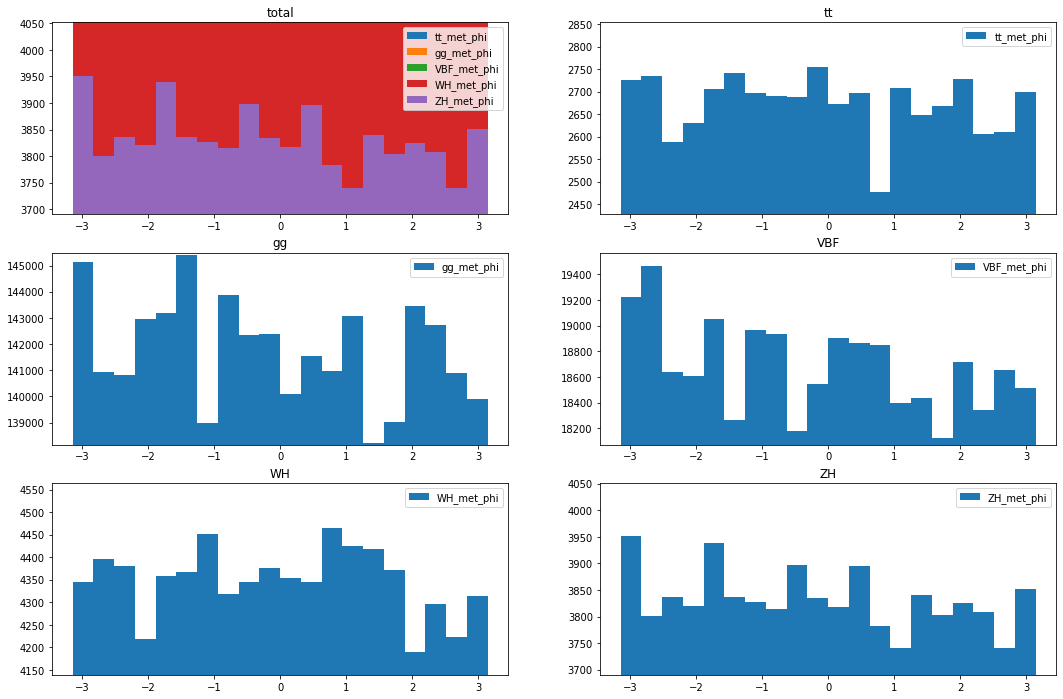

In [45]:
def plot_met_phi(ax, key, events):
    v, _, _ = ax.hist(events[b"met_phi"], weights=events[b"mcWeight"], label=f"{key}_met_phi", bins=20)
    ax.legend()
    ax.set_ylim([np.min(v)-50, np.max(v)+100])
    ax.set_title(key)
per_axis(plot_met_phi, events).savefig("output/met_phi_numbers.png")

In [21]:
def hist_masked(ax, data, weights=None, **kwargs):
    mask = (data != np.nan) & (data != np.infty) & (data != -np.infty)
    return ax.hist(data[mask], weights=weights[mask], **kwargs)

/afs/cern.ch/user/a/ananiev/projects/venvs/sandbox/lib64/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  
/afs/cern.ch/user/a/ananiev/projects/venvs/sandbox/lib64/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/afs/cern.ch/user/a/ananiev/projects/venvs/sandbox/lib64/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """
/afs/cern.ch/user/a/ananiev/projects/venvs/sandbox/lib64/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


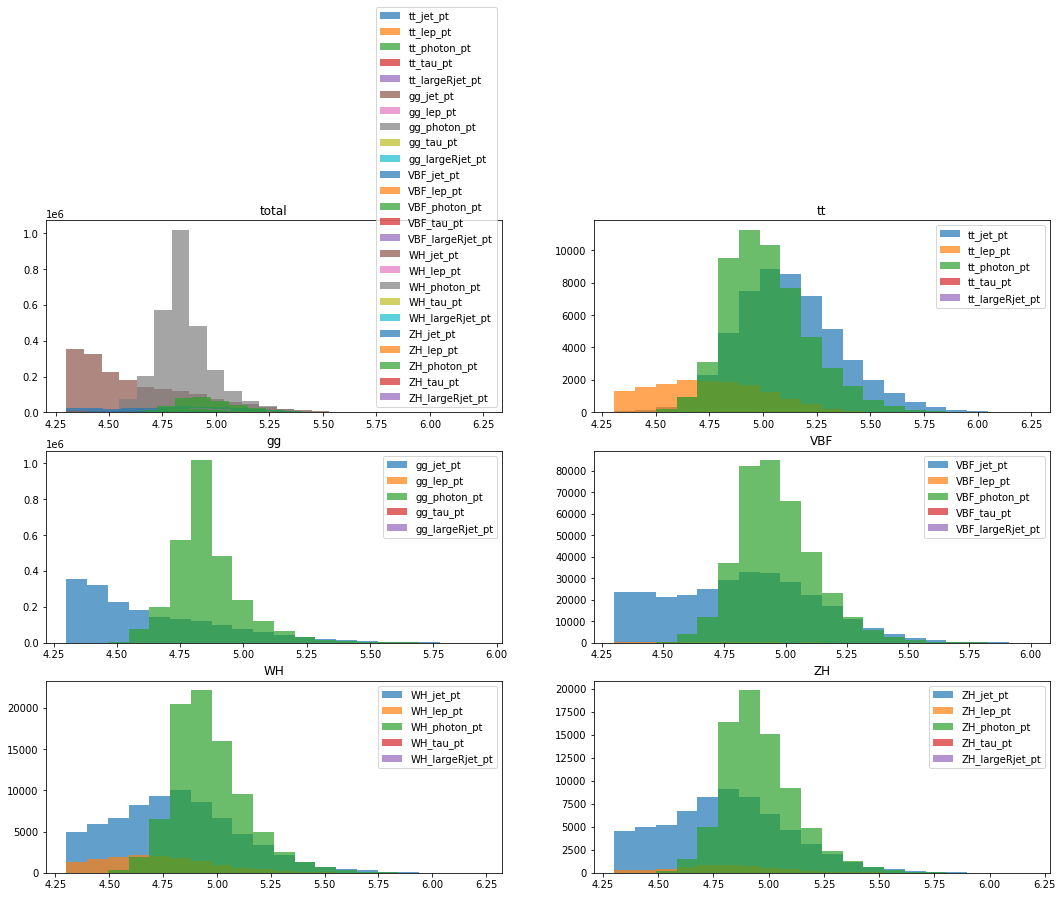

In [28]:
def plot_pt_values(ax, key, events):
    _, bins, _ = hist_masked(ax, np.log10(events[b"jet_pt"].max()), weights=events[b"mcWeight"], label=f"{key}_jet_pt", alpha=0.7, bins=20)
    hist_masked(ax, np.log10(events[b"lep_pt"].max()), weights=events[b"mcWeight"], label=f"{key}_lep_pt", alpha=0.7, bins=bins)
    hist_masked(ax, np.log10(events[b"photon_pt"].max()), weights=events[b"mcWeight"], label=f"{key}_photon_pt", alpha=0.7, bins=bins)
    hist_masked(ax, np.log10(events[b"tau_pt"].max()), weights=events[b"mcWeight"], label=f"{key}_tau_pt", alpha=0.7, bins=bins)
    hist_masked(ax, np.log10(events[b"largeRjet_pt"].max()), weights=events[b"mcWeight"], label=f"{key}_largeRjet_pt", alpha=0.7, bins=bins)
    ax.legend()
    ax.set_title(key)
per_axis(plot_pt_values, events).savefig("output/pt_number.png")